# DIA Capstone: Modeling

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import math

### 1b. Load the data

In [2]:
DIA = pd.read_csv('DIA (3).csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
DIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [4]:
DIA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2015,178.649994,179.229996,176.979996,177.940002,153.454803,4997200
1,1/5/2015,177.059998,177.210007,174.460007,174.839996,150.781387,6700200
2,1/6/2015,175.100006,175.539993,172.320007,173.389999,149.530914,10131400
3,1/7/2015,174.850006,175.789993,174.240005,175.589996,151.428162,5547000
4,1/8/2015,177.259995,178.960007,177.210007,178.759995,154.161942,7166700


In [5]:
DIA.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## 2. ARIMA

### 2a. Cleaning, transforming and visualizing for ARIMA 

In [6]:
DIA['Date'] = pd.to_datetime(DIA['Date'])

In [7]:
DIA = DIA.set_index('Date').asfreq('B').ffill()

In [8]:
y = DIA['Adj Close']

In [9]:
type(y)

pandas.core.series.Series

In [10]:
y.isna().sum()

0

### 2b. Decomposition

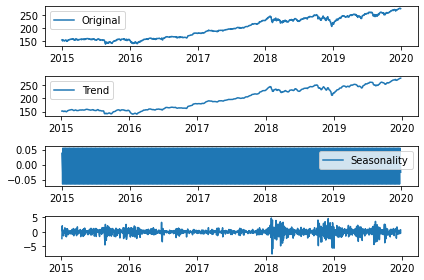

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = "Seasonality")
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = "Residual")
plt.tight_layout()

### 2b. Testing for stationarity with KPSS

In [12]:
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(5.3803298534460815,
 0.01,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### 2c. Making the data stationary 

In [13]:
y_log = np.log(y)

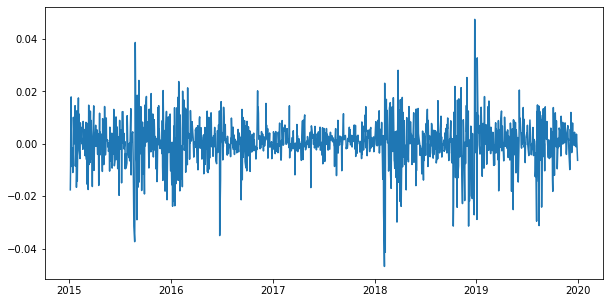

In [14]:
_ = plt.figure(figsize=(10,5))
_ = plt.plot(y_log.diff())

In [15]:
kpss(y_log.diff().dropna())

C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.08738928379019296,
 0.1,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### 2d. The ARIMA model

In [16]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.65) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [17]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [18]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [19]:
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.079
ARIMA(0, 0, 1) MSE=0.021
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 1, 2) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=57123.249
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
Best ARIMA(0, 1, 0) MSE=0.000


In [20]:
p=0
d=1
q=0
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(12)

In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                 1301
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4374.443
Method:                           css   S.D. of innovations              0.008
Date:                Mon, 15 Nov 2021   AIC                          -8744.885
Time:                        21:13:33   BIC                          -8734.543
Sample:                    01-05-2015   HQIC                         -8741.005
                         - 12-30-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.927      0.054   -7.58e-06       0.001
==============================================================================
"""

### 2e. Visualize the results 

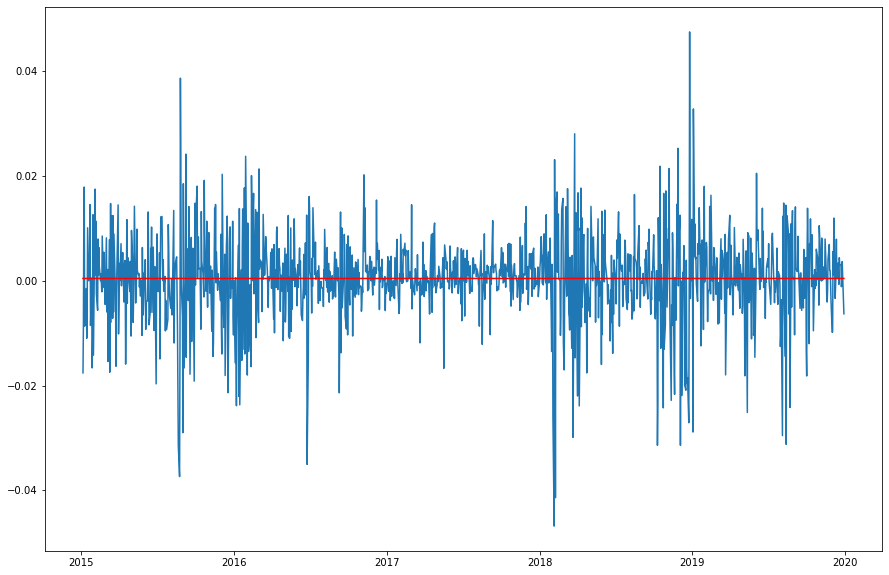

In [22]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color = 'red')

### 2f. Application: Forecasting

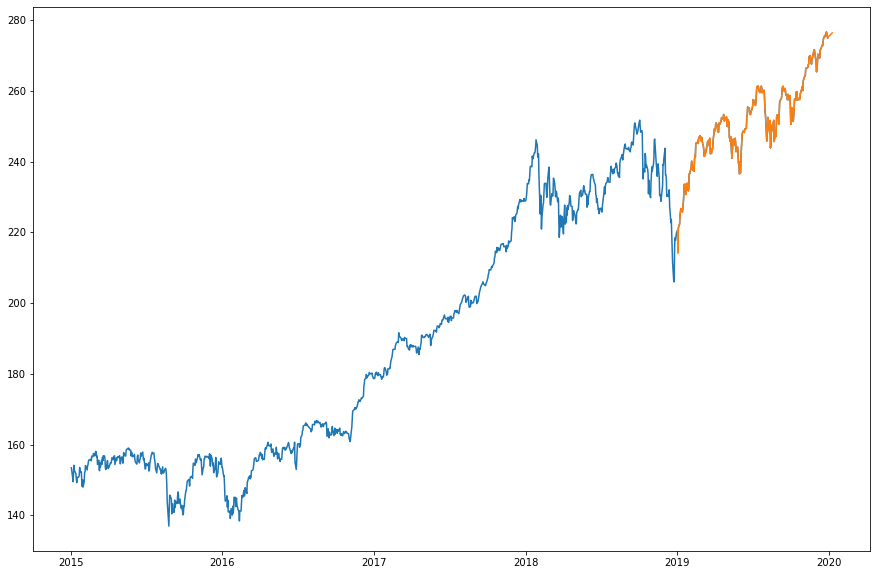

In [23]:
forecast_period = 12
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, \
                           freq='D').strftime("%Y-%m-%d").tolist()

future_dates = pd.DataFrame(date_range, columns = ['Date'])
future_dates['Date'] = pd.to_datetime(future_dates['Date'])
future_dates.set_index('Date', inplace = True)
future_dates['Prediction'] = forecast[0]


plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot(y['2019'].append(np.exp(future_dates['Prediction'])))
plt.show()

## 3. LSTM

### 3a. Cleaning, transforming and visualizing for LSTM

In [24]:
y.head()

Date
2015-01-02    153.454803
2015-01-05    150.781387
2015-01-06    149.530914
2015-01-07    151.428162
2015-01-08    154.161942
Freq: B, Name: Adj Close, dtype: float64

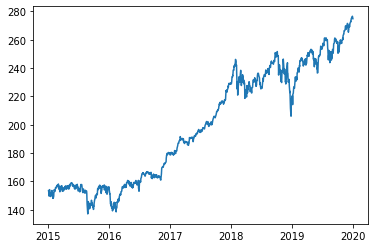

In [25]:
plt.plot(y)
plt.show()

### 3b. Scaling the data

In [26]:
# Scaling the data since LSTM is sensitive to the scale of the data
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(np.array(y).reshape(-1,1))

In [27]:
y

array([[0.11787259],
       [0.09872443],
       [0.089768  ],
       ...,
       [0.99813202],
       [1.        ],
       [0.98754509]])

### 3c. Train, Test split

In [28]:
# train , test split
training_size=int(len(y)*0.65)
test_size=len(y)-training_size
train_data,test_data=y[0:training_size,:],y[training_size:len(y),:1]

In [29]:
training_size,test_size

(846, 456)

In [30]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [32]:
X_train.shape, y_train.shape

((745, 100), (745,))

In [33]:
X_test.shape, y_test.shape

((355, 100), (355,))

In [34]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### 3d. The LSTM model

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 293ms/step - loss: 0.0431 - val_loss: 0.0318
Epoch 2/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 3/100
12/12 [==============================] - 2s 190ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 4/100
12/12 [==============================] - 2s 190ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 5/100
12/12 [==============================] - 2s 179ms/step - loss: 8.7643e-04 - val_loss: 0.0028
Epoch 6/100
12/12 [==============================] - 2s 160ms/step - loss: 7.8498e-04 - val_loss: 0.0027
Epoch 7/100
12/12 [==============================] - 2s 156ms/step - loss: 8.2930e-04 - val_loss: 0.0029
Epoch 8/100
12/12 [==============================] - 2s 158ms/step - loss: 7.7148e-04 - val_loss: 0.0024
Epoch 9/100
12/12 [==============================] - 2s 174ms/step - loss: 7.0806e-04 - val_loss: 0.0020
Epoch 10/100
12/12 [==============================] - 2s 163ms/step - l

12/12 [==============================] - 2s 157ms/step - loss: 4.2207e-04 - val_loss: 0.0038
Epoch 79/100
12/12 [==============================] - 2s 158ms/step - loss: 4.7618e-04 - val_loss: 0.0025
Epoch 80/100
12/12 [==============================] - 2s 157ms/step - loss: 4.3951e-04 - val_loss: 0.0014
Epoch 81/100
12/12 [==============================] - 2s 175ms/step - loss: 4.2853e-04 - val_loss: 0.0019
Epoch 82/100
12/12 [==============================] - 2s 164ms/step - loss: 3.9107e-04 - val_loss: 0.0029
Epoch 83/100
12/12 [==============================] - 2s 154ms/step - loss: 3.8260e-04 - val_loss: 0.0014
Epoch 84/100
12/12 [==============================] - 2s 158ms/step - loss: 3.9266e-04 - val_loss: 0.0020
Epoch 85/100
12/12 [==============================] - 2s 159ms/step - loss: 3.8830e-04 - val_loss: 0.0017
Epoch 86/100
12/12 [==============================] - 2s 180ms/step - loss: 4.0309e-04 - val_loss: 0.0019
Epoch 87/100
12/12 [==============================] - 2s 16

In [37]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [38]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [39]:
np.sqrt(mean_squared_error(y_train, train_predict))

180.91826496723417

In [40]:
np.sqrt(mean_squared_error(y_test,test_predict))

246.27411940751463

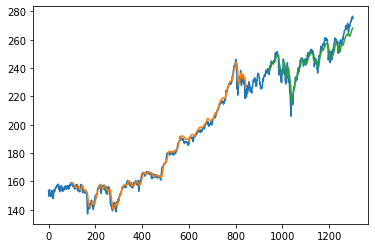

In [41]:
# Plotting 
look_back=100
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(y)-1, :] = test_predict
# plot
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [42]:
len(test_data)

456

In [43]:
x_input=test_data[356:].reshape(1,-1)
x_input.shape

(1, 100)

In [44]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [45]:
_ = temp_input

In [46]:
# prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9418777]
101
1 day input [0.76523263 0.77399616 0.79592248 0.81280976 0.80148282 0.81754682
 0.82118498 0.77814263 0.79743275 0.78850824 0.80628864 0.83038338
 0.83196229 0.83196229 0.81335905 0.83058917 0.85633255 0.86072601
 0.8640211  0.86807139 0.88386096 0.88818535 0.89010776 0.88029111
 0.88296806 0.8857825  0.8820074  0.87152737 0.87228387 0.86271902
 0.87379754 0.86898135 0.86285651 0.87104539 0.84572246 0.81283009
 0.82170728 0.84682322 0.84049238 0.81874868 0.83147802 0.84235009
 0.864027   0.8619623  0.87820192 0.87723864 0.8793027  0.86162722
 0.86555226 0.86286635 0.8657586  0.86396821 0.87512345 0.88345485
 0.88386796 0.88985902 0.88118292 0.90087481 0.90920708 0.91099725
 0.91092796 0.92642135 0.92655862 0.92717852 0.9280736  0.93330641
 0.9345462  0.94988811 0.9521644  0.94567957 0.93788522 0.93457395
 0.94243737 0.95582038 0.95968334 0.96347811 0.96347811 0.95685535
 0.93788522 0.91932886 0.92995164 0.93209045 0.95513075 0.94864614
 0.94657706 0.94836986 0.96375396 

11 day output [[0.84476197]]
12 day input [0.83038338 0.83196229 0.83196229 0.81335905 0.83058917 0.85633255
 0.86072601 0.8640211  0.86807139 0.88386096 0.88818535 0.89010776
 0.88029111 0.88296806 0.8857825  0.8820074  0.87152737 0.87228387
 0.86271902 0.87379754 0.86898135 0.86285651 0.87104539 0.84572246
 0.81283009 0.82170728 0.84682322 0.84049238 0.81874868 0.83147802
 0.84235009 0.864027   0.8619623  0.87820192 0.87723864 0.8793027
 0.86162722 0.86555226 0.86286635 0.8657586  0.86396821 0.87512345
 0.88345485 0.88386796 0.88985902 0.88118292 0.90087481 0.90920708
 0.91099725 0.91092796 0.92642135 0.92655862 0.92717852 0.9280736
 0.93330641 0.9345462  0.94988811 0.9521644  0.94567957 0.93788522
 0.93457395 0.94243737 0.95582038 0.95968334 0.96347811 0.96347811
 0.95685535 0.93788522 0.91932886 0.92995164 0.93209045 0.95513075
 0.94864614 0.94657706 0.94836986 0.96375396 0.96485757 0.97148033
 0.97375574 0.97244492 0.98106856 0.98706071 0.99308041 0.99086663
 0.99086663 0.99813202

22 day output [[0.81116736]]
23 day input [0.89010776 0.88029111 0.88296806 0.8857825  0.8820074  0.87152737
 0.87228387 0.86271902 0.87379754 0.86898135 0.86285651 0.87104539
 0.84572246 0.81283009 0.82170728 0.84682322 0.84049238 0.81874868
 0.83147802 0.84235009 0.864027   0.8619623  0.87820192 0.87723864
 0.8793027  0.86162722 0.86555226 0.86286635 0.8657586  0.86396821
 0.87512345 0.88345485 0.88386796 0.88985902 0.88118292 0.90087481
 0.90920708 0.91099725 0.91092796 0.92642135 0.92655862 0.92717852
 0.9280736  0.93330641 0.9345462  0.94988811 0.9521644  0.94567957
 0.93788522 0.93457395 0.94243737 0.95582038 0.95968334 0.96347811
 0.96347811 0.95685535 0.93788522 0.91932886 0.92995164 0.93209045
 0.95513075 0.94864614 0.94657706 0.94836986 0.96375396 0.96485757
 0.97148033 0.97375574 0.97244492 0.98106856 0.98706071 0.99308041
 0.99086663 0.99086663 0.99813202 1.         0.98754509 0.94187772
 0.93750405 0.92958009 0.91951108 0.90848792 0.89734316 0.88659239
 0.87652206 0.867273

In [47]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [48]:
len(y)

1302

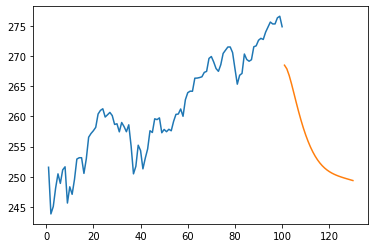

In [49]:
plt.plot(day_new,scaler.inverse_transform(y[1202:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

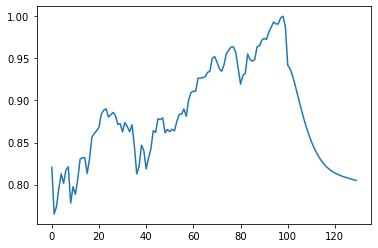

In [50]:
z=y.tolist()
z.extend(lst_output)
plt.plot(z[1202:])

In [51]:
z=scaler.inverse_transform(z).tolist()

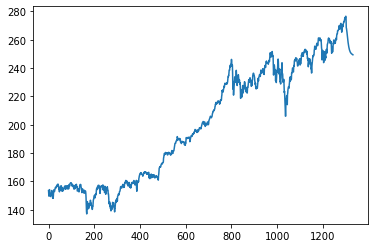

In [52]:
plt.plot(z)

### 4. Conclusion

We used both the ARIMA model and LSTM model to try to predict future stock price of DIA (SPDR Dow Jones Industrial Average ETF Trust). A lot of people wants to be able to predict the stock prices, but stock prices are very hard/almost impossible to predict. ARIMA model is better short term forecasting, while LSTM is better for long term modeling. Making better models for DIA are beyond the scope of this capstone and require more knowledge and skills which I would acquire as time goes on. For businesses, picking ARIMA vs LSTM is cost vs benefit. LSTM gives better prediction result, but at the cost of more complexity. The best ARIMA we got for DIA is ARIMA(0, 1, 0) because it had the lowest MSE, meaning that DIA is a random walk. This goes in line with the Random Walk theory and the Efficient Market Hypothesis. The LSTM model was able to predict the general trend of which way DIA was going, but I would say the LSTM model we used for this project is unreliable and should not be used to decide when to pick and sell stocks. There maybe a better model out there that might be able to predict the prices of DIA, but that is beyond the scope of this project.

resources:
* https://github.com/krishnaik06/Stock-MArket-Forecasting/blob/master/Untitled.ipynb
* https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
* https://datascience.stackexchange.com/questions/12721/time-series-prediction-using-arima-vs-lstm
* https://www.researchgate.net/publication/339600773_Forecasting_Financial_Budget_Time_Series_ARIMA_Random_Walk_vs_LSTM_Neural_Network
* https://www.investopedia.com/terms/r/randomwalktheory.asp